<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/comparesimulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
! apt update -q
! apt-get install -q openjdk-25-jdk-headless
!pip install neqsim -q
!pip install wget
!wget https://raw.githubusercontent.com/EvenSol/NeqSim-Colab/master/notebooks/PVT/examplefile.txt
from neqsim import jneqsim as neqsim

# Scope of work

In  this workbook we establish a neqsim simulation of a typical offshore oil and gas process and compare to results from HYSYS and DWSIM as presented in the work by A. Andreasen (https://github.com/andr1976/dwsim-paper).

Paper with results:

https://github.com/andr1976/dwsim-paper/blob/main/paper/Revised_Paper_ANRA.pdf

Fluid characterization given in paper:

https://onlinelibrary.wiley.com/doi/abs/10.1002/apj.159

Background info:

https://www.mdpi.com/2305-7084/4/1/11

#  Introduction to Gas Processing using NeqSim
To learn about how to use NeqSim for gas processing applications see [Introduction to Gas Processing using NeqSim and Python](https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/examples_of_NeqSim_in_Colab.ipynb).

# Create well fluid
The well fluid is created based on fluid characterization given in the papers.

In [2]:
wellfluid = neqsim.thermo.system.SystemPrEos()
wellfluid.getCharacterization().setTBPModel("Two")
wellfluid.addComponent("CO2", 1.5870)
wellfluid.addComponent("methane", 52.51)
wellfluid.addComponent("ethane", 6.24)
wellfluid.addComponent("propane", 4.23)
wellfluid.addComponent("i-butane", 0.855)
wellfluid.addComponent("n-butane", 2.213)
wellfluid.addComponent("i-pentane", 1.124)
wellfluid.addComponent("n-pentane", 1.271)
wellfluid.addComponent("n-hexane", 2.289)
wellfluid.addTBPfraction("C7+_cut1", 0.8501, 108.47 / 1000.0, 0.7411)
wellfluid.addTBPfraction("C7+_cut2", 1.2802, 120.4 / 1000.0, 0.755)
wellfluid.addTBPfraction("C7+_cut3", 1.6603, 133.64 / 1000.0, 0.7695)
wellfluid.addTBPfraction("C7+_cut4", 6.5311, 164.70 / 1000.0, 0.799)
wellfluid.addTBPfraction("C7+_cut5", 6.3311, 215.94 / 1000.0, 0.8387)
wellfluid.addTBPfraction("C7+_cut6", 4.9618, 273.34 / 1000.0, 0.8754)
wellfluid.addTBPfraction("C7+_cut7", 2.9105, 334.92 / 1000.0, 0.90731)
wellfluid.addTBPfraction("C7+_cut8", 3.0505, 412.79 / 1000.0, 0.94575)
wellfluid.setMixingRule("classic")
#wellfluid.setMultiPhaseCheck(True) #not needed as we will have maximum two phases
#wellfluid.useVolumeCorrection(False) #It seems as volume correction was not used in the papers. To be checked.

Alternative use the Eclipse fluid model configuration script to create the fluid

In [3]:
from neqsim.thermo.thermoTools import readEclipseFluid, printFrame, TPflash
wellfluid_eclipse = readEclipseFluid('examplefile.txt')
wellfluid_eclipse.setMultiPhaseCheck(True)
#TPflash(wellfluid_eclipse)
#printFrame (wellfluid_eclipse)

Run a TPflash on well fluid at standard conditions and report the properties presented in the papers.

In [4]:
from neqsim.thermo.thermoTools import printFrame, TPflash
wellfluid.setPressure(0.0, "barg")
wellfluid.setTemperature(15.0, "C")
TPflash(wellfluid)
printFrame (wellfluid)

print('GOR ', wellfluid.getPhase("gas").getNumberOfMolesInPhase()/wellfluid.getPhase("oil").getNumberOfMolesInPhase())
print('Gas molecular weight ', wellfluid.getPhase("gas").getMolarMass('gr/mol'))
print('Oil molecular weight ', wellfluid.getPhase("oil").getMolarMass('gr/mol'))
print('gas density ',  wellfluid.getPhase("gas").getDensity('kg/m3'))
print('oil density ',  wellfluid.getPhase("oil").getDensity('kg/m3'))

| 0                    | 1          | 2           | 3           | 4   | 5   | 6               |
|:---------------------|:-----------|:------------|:------------|:----|:----|:----------------|
|                      | total      | GAS         | OIL         |     |     |                 |
| CO2                  | 1.58867E-2 | 2.3019E-2   | 3.55518E-4  |     |     | [mole fraction] |
| methane              | 5.25654E-1 | 7.65266E-1  | 3.8718E-3   |     |     | [mole fraction] |
| ethane               | 6.24658E-2 | 8.9697E-2   | 3.16688E-3  |     |     | [mole fraction] |
| propane              | 4.23446E-2 | 5.80354E-2  | 8.17614E-3  |     |     | [mole fraction] |
| i-butane             | 8.55902E-3 | 1.07181E-2  | 3.85745E-3  |     |     | [mole fraction] |
| n-butane             | 2.21533E-2 | 2.57699E-2  | 1.42779E-2  |     |     | [mole fraction] |
| i-pentane            | 1.12519E-2 | 9.80198E-3  | 1.44091E-2  |     |     | [mole fraction] |
| n-pentane            | 1.27234E-2 | 9.

# Phase envelope and critical properties of the well fluid

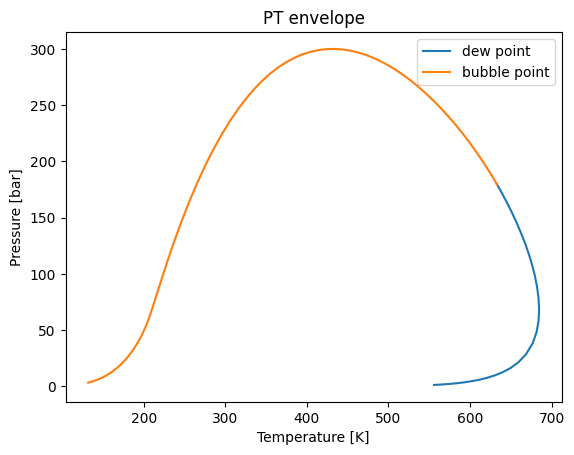

cricobarP  300.17224420882684   bara   cricobarT  434.4720715734585  K
cricothermP  68.38357269776058   bara   cricothermT  684.6263408810898  K
critical temperature  [K]  632.8284115025867  critical pressure  [bara]  179.8395715752153


In [5]:
import matplotlib.pyplot as plt

thermoOps = neqsim.thermodynamicoperations.ThermodynamicOperations(wellfluid.clone())
thermoOps.calcPTphaseEnvelope()

plt.plot(list(thermoOps.getOperation().get("dewT")),list(thermoOps.getOperation().get("dewP")), label="dew point")
plt.plot(list(thermoOps.getOperation().get("bubT")),list(thermoOps.getOperation().get("bubP")), label="bubble point")
plt.title('PT envelope')
plt.xlabel('Temperature [K]')
plt.ylabel('Pressure [bar]')
plt.legend()
plt.show()

cricobar = thermoOps.getOperation().get("cricondenbar")
cricotherm = thermoOps.getOperation().get("cricondentherm")
print("cricobarP ",  cricobar[1], "  bara ", " cricobarT ", cricobar[0], " K")
print("cricothermP ",  cricotherm[1], "  bara ", " cricothermT ", cricotherm[0], " K")
print('critical temperature  [K] ', thermoOps.getOperation().get("criticalPoint1")[0], ' critical pressure  [bara] ', thermoOps.getOperation().get("criticalPoint1")[1] )

# Establish the process model using NeqSim
In this notebook we will use the pydantic framework for implementing the model. This framework is well suited for implementing the model as an API, enables checking of validity of input parameters, API documentation, and  enables fast implementation of the model in a cloud framework (eg. used for running live process simulation or use in process digital twins).

The process flow diagram is presented in:

Andreasen, A. Applied Process Simulation-Driven Oil and Gas Separation Plant Optimization Using Surrogate Modeling and Evolutionary Algorithms. ChemEngineering 2020, 4, 11. https://doi.org/10.3390/chemengineering4010011


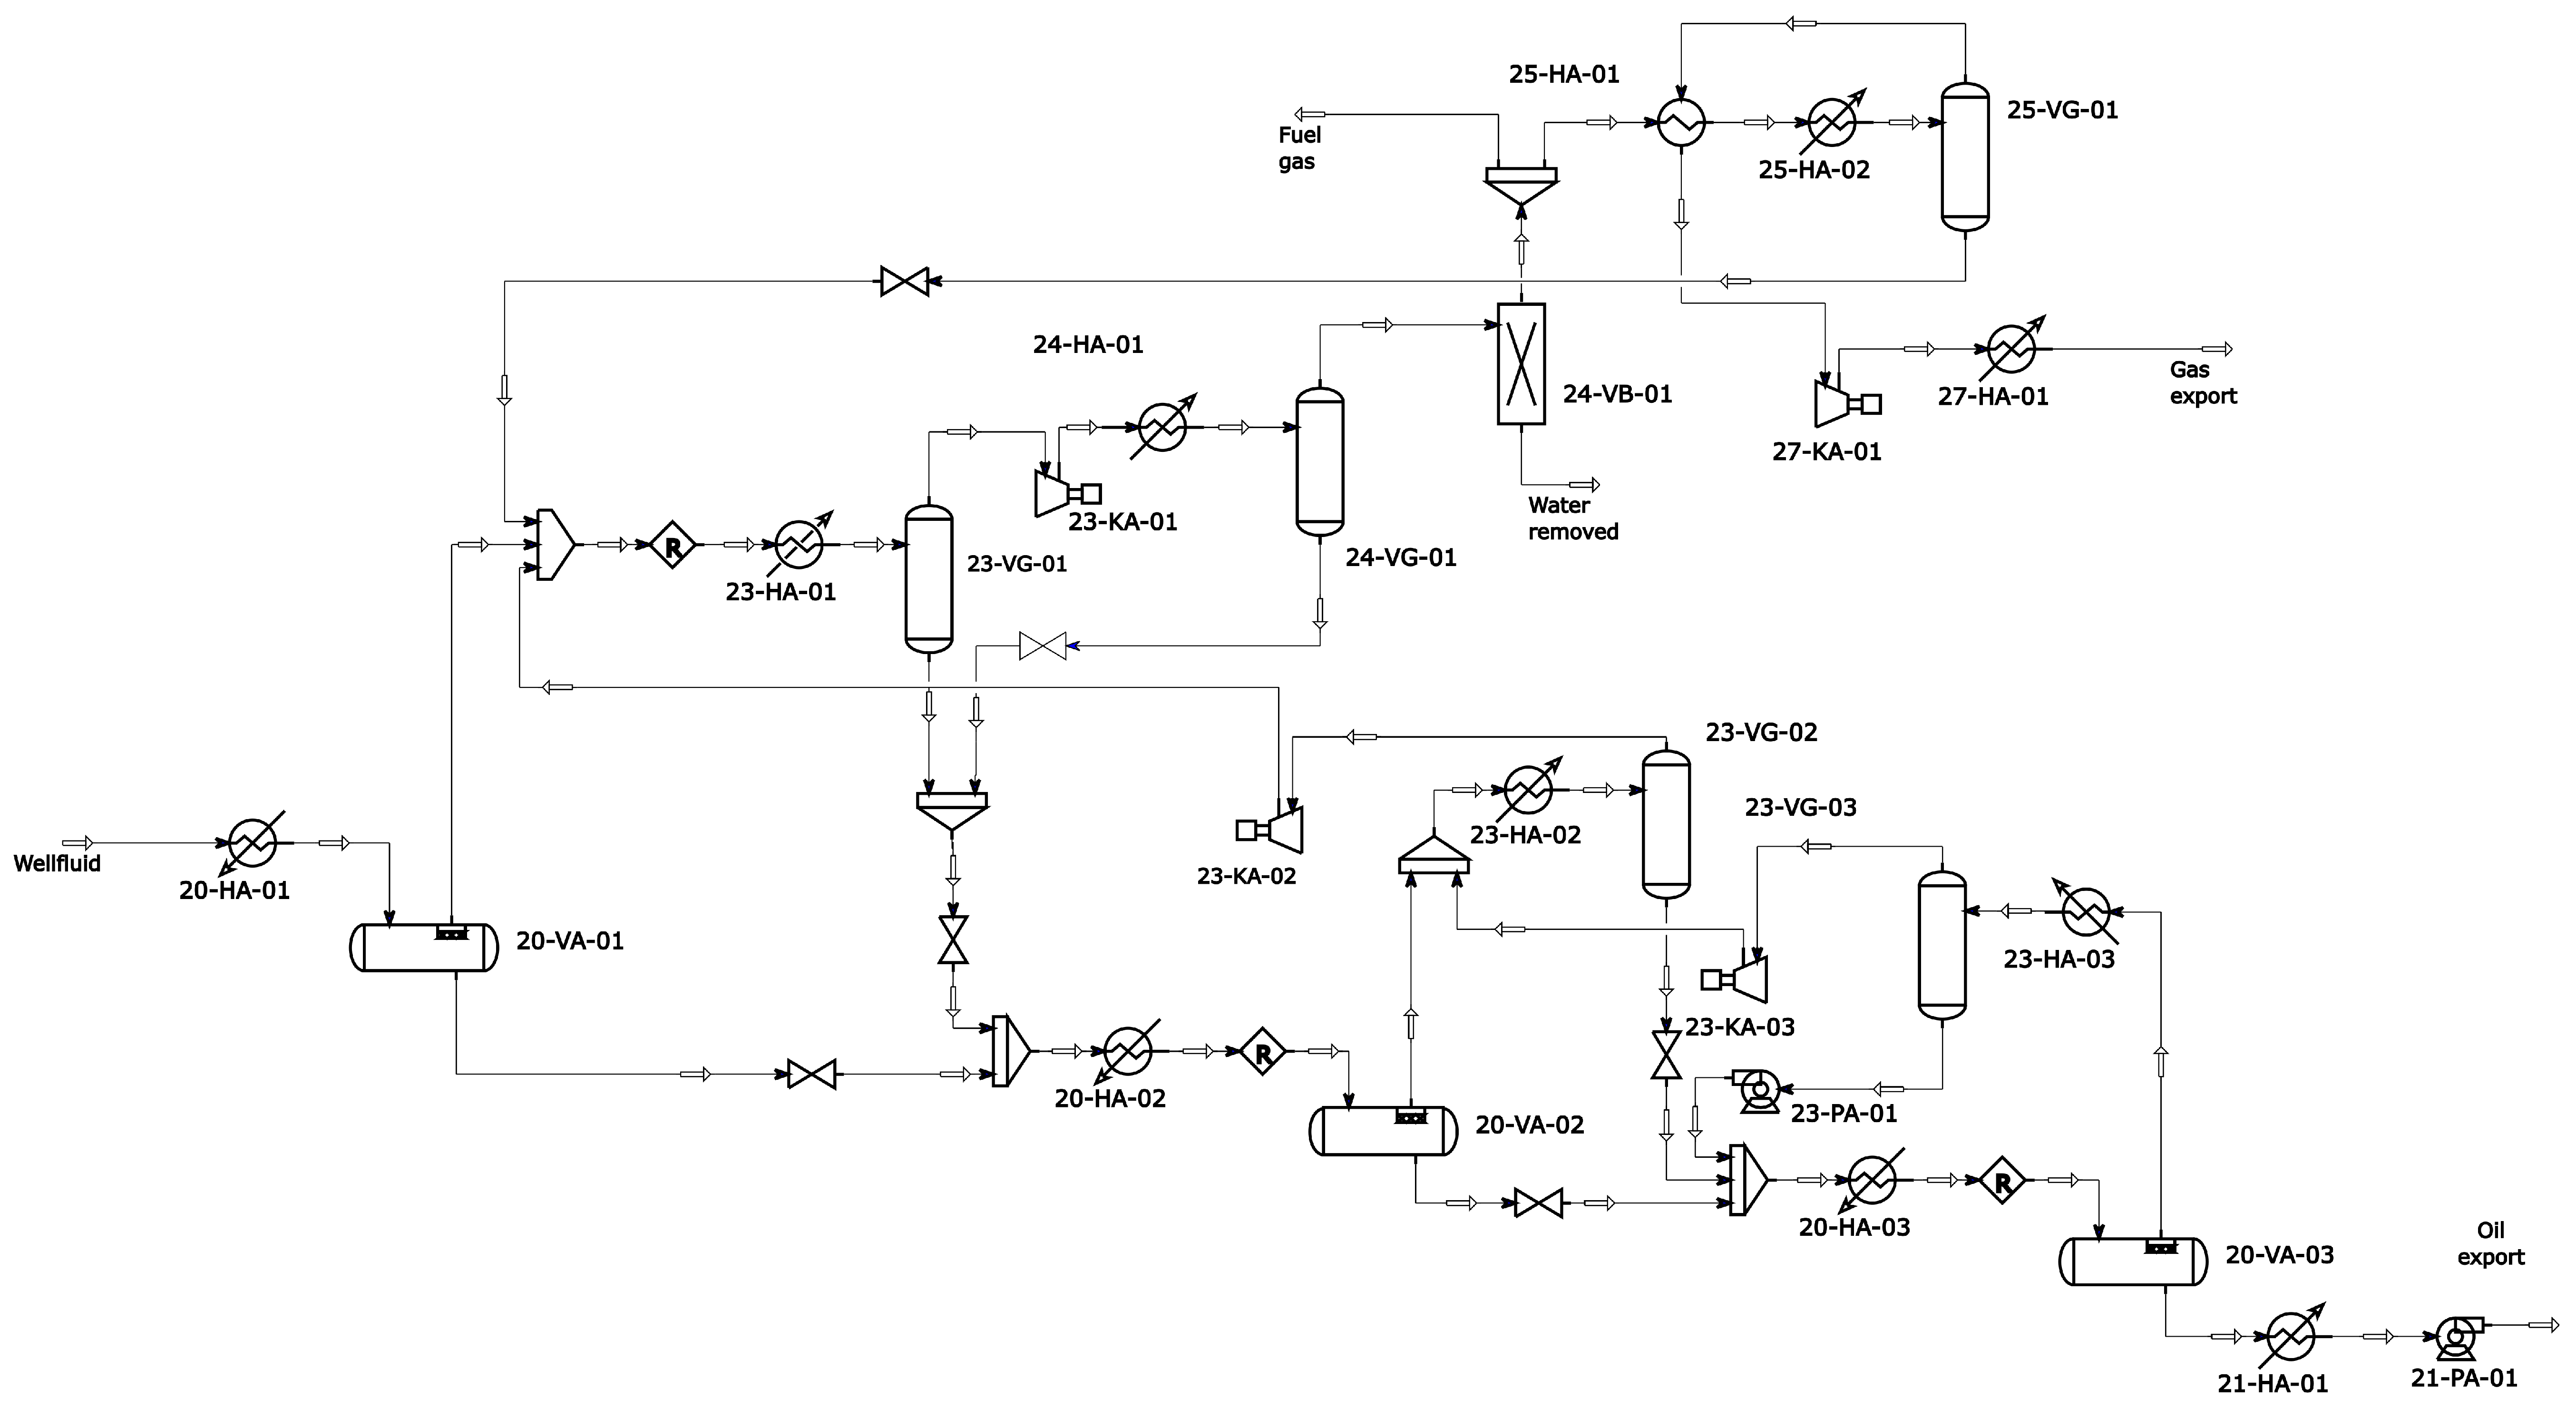

In [6]:
import json
from typing import Optional, List

import pandas as pd
from pydantic.dataclasses import dataclass
from pydantic import Field, field_validator

# Import or reference the neqsim library
# import neqsim  # Uncomment this if needed, depending on your environment.

@dataclass
class ProcessInput:
    """
    A data class to define input parameters for an oil and gas process simulation
    using the NEQSim process modeling library.

    This class uses Pydantic to structure and validate the input parameters
    required for running the simulation. It ensures that the input data is of
    the correct type and within acceptable ranges.

    Attributes:
        feed_rate (float): Molar flow rate [kgmole/hr].
        molar_composition (List[float]): Molar composition of well fluid [mole fraction].
            Must contain exactly 17 components.
        Psep1 (float): Pressure of first stage separator [barg].
        Tsep1 (float): Temperature of first stage separator [°C].
        Psep2 (float): Pressure of second stage separator [barg].
        Tsep2 (float): Temperature of second stage separator [°C].
        Psep3 (float): Pressure of third stage separator [barg].
        Tsep3 (float): Temperature of third stage separator [°C].
        Tscrub1 (float): Temperature of first stage recompressor scrubber [°C].
        Tscrub2 (float): Temperature of second stage recompressor scrubber [°C].
        Tscrub3 (float): Temperature of third stage recompressor scrubber [°C].
        Tscrub4 (float): Temperature of fourth stage recompressor scrubber [°C].
        Pcomp1 (float): Pressure after 1st stage export compressor [barg].
        Trefig (float): Temperature after cooling export gas [°C].
        P_oil_export (float): Pressure after oil export pump [barg].
        T_oil_export (float): Temperature of export oil [°C].
        P_gas_export (float): Pressure of export gas [barg].
        T_gas_export (float): Temperature of export gas [°C].
        dP_20_HA_01 (float): Pressure drop over heater 20-HA-01 [bar].
        dP_20_HA_02 (float): Pressure drop over heater 20-HA-02 [bar].
        dP_20_HA_03 (float): Pressure drop over heater 20-HA-03 [bar].
        dP_21_HA_01 (float): Pressure drop over heater 21-HA-01 [bar].
        dP_23_HA_01 (float): Pressure drop over heater 23-HA-01 [bar].
        dP_23_HA_02 (float): Pressure drop over heater 23-HA-02 [bar].
        dP_23_HA_03 (float): Pressure drop over heater 23-HA-03 [bar].
        dP_24_HA_01 (float): Pressure drop over heater 24-HA-01 [bar].
        dP_25_HA_01 (float): Pressure drop over heater 25-HA-01 [bar].
        dP_25_HA_02 (float): Pressure drop over heater 25-HA-02 [bar].
        dP_27_HA_01 (float): Pressure drop over heater 27-HA-01 [bar].
    """

    feed_rate: float = Field(title="molar flow rate [kgmole/hr]")
    molar_composition: List[float] = Field(title="molar composition of well fluid [molefraction]")
    Psep1: float = Field(ge=0.0, le=100.0, title="Pressure of first stage separator [barg]")
    Tsep1: float = Field(ge=0.0, le=100.0, title="Temperature of first stage separator [C]")
    Psep2: float = Field(ge=0.0, le=100.0, title="Pressure of second stage separator [barg]")
    Tsep2: float = Field(ge=0.0, le=100.0, title="Temperature of second stage separator [C]")
    Psep3: float = Field(ge=0.0, le=100.0, title="Pressure of third stage separator [barg]")
    Tsep3: float = Field(ge=0.0, le=100.0, title="Temperature of third stage separator [C]")
    Tscrub1: float = Field(ge=0.0, le=100.0, title="Temperature of first stage recompressor scrubber [C]")
    Tscrub2: float = Field(ge=0.0, le=100.0, title="Temperature of second stage recompressor scrubber [C]")
    Tscrub3: float = Field(ge=0.0, le=100.0, title="Temperature of third stage recompressor scrubber [C]")
    Tscrub4: float = Field(ge=0.0, le=100.0, title="Temperature of fourth stage recompressor scrubber [C]")
    Pcomp1: float = Field(ge=0.0, le=100.0, title="Pressure after 1st stage export compressor [barg]")
    Trefig: float = Field(ge=0.0, le=100.0, title="Temperature after cooling export gas [C]")
    P_oil_export: float = Field(ge=0.0, le=200.0, title="Pressure after oil export pump [barg]")
    T_oil_export: float = Field(ge=0.0, le=100.0, title="Temperature of export oil [C]")
    P_gas_export: float = Field(ge=0.0, le=300.0, title="Pressure of export gas [barg]")
    T_gas_export: float = Field(ge=0.0, le=100.0, title="Temperature of export gas [C]")
    dP_20_HA_01: float = Field(ge=0.0, le=10.0, title="Pressure drop over heater 20-HA-01 [bar]")
    dP_20_HA_02: float = Field(ge=0.0, le=10.0, title="Pressure drop over heater 20-HA-02 [bar]")
    dP_20_HA_03: float = Field(ge=0.0, le=10.0, title="Pressure drop over heater 20-HA-03 [bar]")
    dP_21_HA_01: float = Field(ge=0.0, le=10.0, title="Pressure drop over heater 21-HA-01 [bar]")
    dP_23_HA_01: float = Field(ge=0.0, le=10.0, title="Pressure drop over heater 23-HA-01 [bar]")
    dP_23_HA_02: float = Field(ge=0.0, le=10.0, title="Pressure drop over heater 23-HA-02 [bar]")
    dP_23_HA_03: float = Field(ge=0.0, le=10.0, title="Pressure drop over heater 23-HA-03 [bar]")
    dP_24_HA_01: float = Field(ge=0.0, le=10.0, title="Pressure drop over heater 24-HA-01 [bar]")
    dP_25_HA_01: float = Field(ge=0.0, le=10.0, title="Pressure drop over heater 25-HA-01 [bar]")
    dP_25_HA_02: float = Field(ge=0.0, le=10.0, title="Pressure drop over heater 25-HA-02 [bar]")
    dP_27_HA_01: float = Field(ge=0.0, le=10.0, title="Pressure drop over heater 27-HA-01 [bar]")

    @field_validator("molar_composition")
    def check_mole_rates(cls, v):
        """
        Validates that the molar composition list has exactly 17 components.
        """
        if len(v) != 17:
            raise ValueError("Molar composition should have 17 components.")
        return v


@dataclass
class ProcessOutput:
    """
    A data class to define output results from an oil and gas process simulation.

    Attributes:
        mass_balance (Optional[float]): The mass balance result (percentage).
        results (Optional[dict]): A dictionary containing simulation results
            retrieved from the NEQSim process model JSON report.
    """
    mass_balance: Optional[float] = None
    results: Optional[dict] = None


def getprocess():
    """
    Create and return a NEQSim oil process object using default or
    dummy fluid/stream components. This function demonstrates the
    general structure of a multi-stage oil and gas separation process
    with scrubbing, compressing, cooling, and pumping steps.

    Returns:
        A NEQSim ProcessSystem object representing the oil and gas
        separation process.
    """
    # NOTE:
    #   The following code presupposes that `wellfluid` and `neqsim.process`
    #   are available in your environment. If they are not, you will need
    #   to provide them or modify references accordingly.
    #   The lines below are placeholders for demonstration.

    # Create a reference fluid (ensure 'wellfluid' is defined or created externally)
    wellstream = neqsim.process.equipment.stream.Stream("well stream", wellfluid)
    wellstream.setTemperature(60.0, 'C')
    wellstream.setPressure(33.01, 'bara')

    # Heater
    well_stream_cooler = neqsim.process.equipment.heatexchanger.Heater("20-HA-01", wellstream)

    # First-stage separator
    first_stage_separator = neqsim.process.equipment.separator.ThreePhaseSeparator(
        "20-VA-01", well_stream_cooler.getOutStream()
    )

    # Throttling valve from first-stage separator oil out
    oilvalve1 = neqsim.process.equipment.valve.ThrottlingValve(
        "VLV-100", first_stage_separator.getOilOutStream()
    )

    # Mixer for second-stage inlet
    oil_2nd_stage_mixer = neqsim.process.equipment.mixer.Mixer("MIX-101")
    oil_2nd_stage_mixer.addStream(oilvalve1.getOutStream())

    # Heater
    oilHeaterFromFirstStage = neqsim.process.equipment.heatexchanger.Heater(
        "20-HA-02", oil_2nd_stage_mixer.getOutStream()
    )

    # Second-stage separator
    seccond_stage_separator = neqsim.process.equipment.separator.ThreePhaseSeparator(
        "20-VA-02", oilHeaterFromFirstStage.getOutStream()
    )

    # Throttling valve from second-stage separator oil out
    oilvalve2 = neqsim.process.equipment.valve.ThrottlingValve(
        "VLV-102", seccond_stage_separator.getOilOutStream()
    )

    # Reflux from well stream (for demonstration, setFlowRate is trivial)
    oilreflux = wellstream.clone()
    oilreflux.setName("third stage reflux")
    oilreflux.setFlowRate(1e-6, 'kg/hr')

    # Mixer for third-stage inlet
    thirdstageoilmixer = neqsim.process.equipment.mixer.Mixer("MIX-102")
    thirdstageoilmixer.addStream(oilvalve2.getOutStream())
    thirdstageoilmixer.addStream(oilreflux)

    # Heater
    oilHeaterFromSeccondStage = neqsim.process.equipment.heatexchanger.Heater(
        "20-HA-03", thirdstageoilmixer.getOutletStream()
    )

    # Third-stage separator
    third_stage_separator = neqsim.process.equipment.separator.ThreePhaseSeparator(
        "20-VA-03", oilHeaterFromSeccondStage.getOutStream()
    )

    # Cooler
    firstStageCooler = neqsim.process.equipment.heatexchanger.Cooler(
        "23-HA-03", third_stage_separator.getGasOutStream()
    )

    # Scrubber
    firstStageScrubber = neqsim.process.equipment.separator.Separator(
        "23-VG-03", firstStageCooler.getOutStream()
    )

    # Pump
    firststagescrubberpump = neqsim.process.equipment.pump.Pump(
        "23-PA-01", firstStageScrubber.getLiquidOutStream()
    )

    # Recycle
    lp_resycle = neqsim.process.equipment.util.Recycle("LP oil resycle")
    lp_resycle.addStream(firststagescrubberpump.getOutStream())
    lp_resycle.setOutletStream(oilreflux)
    lp_resycle.setTolerance(1e-6)

    # First-stage recompressor
    first_stage_recompressor = neqsim.process.equipment.compressor.Compressor(
        "23-KA-03", firstStageScrubber.getGasOutStream()
    )
    first_stage_recompressor.setIsentropicEfficiency(0.75)

    # Mixer combining first-stage recompressor gas and second-stage separator gas
    firststagegasmixer = neqsim.process.equipment.mixer.Mixer("MIX-103")
    firststagegasmixer.addStream(first_stage_recompressor.getOutStream())
    firststagegasmixer.addStream(seccond_stage_separator.getGasOutStream())

    # Second-stage cooler
    seccond_stage_cooler = neqsim.process.equipment.heatexchanger.Cooler(
        "23-HA-02", firststagegasmixer.getOutStream()
    )

    # Second-stage scrubber
    seccond_stage_scrubber = neqsim.process.equipment.separator.Separator(
        "23-VG-02", seccond_stage_cooler.getOutStream()
    )

    # Add second-stage scrubber liquid to third-stage oil mixer
    thirdstageoilmixer.addStream(seccond_stage_scrubber.getLiquidOutStream())

    # Second-stage recompressor
    seccond_stage_recompressor = neqsim.process.equipment.compressor.Compressor(
        "23-KA-02", seccond_stage_scrubber.getGasOutStream()
    )
    seccond_stage_recompressor.setIsentropicEfficiency(0.75)

    # Mixer combining second-stage recompressor gas and first-stage separator gas
    exportgasmixer = neqsim.process.equipment.mixer.Mixer("MIX-100")
    exportgasmixer.addStream(seccond_stage_recompressor.getOutStream())
    exportgasmixer.addStream(first_stage_separator.getGasOutStream())

    # Dew point cooler
    dew_point_cooler = neqsim.process.equipment.heatexchanger.Cooler(
        "23-HA-01", exportgasmixer.getOutStream()
    )

    # Dew point scrubber
    dew_point_scrubber = neqsim.process.equipment.separator.Separator(
        "23-VG-01", dew_point_cooler.getOutStream()
    )

    # Add dew point scrubber liquid to second-stage mixer
    oil_2nd_stage_mixer.addStream(dew_point_scrubber.getLiquidOutStream())

    # First stage export compressor
    first_stage_export_compressor = neqsim.process.equipment.compressor.Compressor(
        "23-KA-01", dew_point_scrubber.getGasOutStream()
    )
    first_stage_export_compressor.setIsentropicEfficiency(0.75)

    # Cooler after first stage export compressor
    dew_point_cooler2 = neqsim.process.equipment.heatexchanger.Cooler(
        "24-HA-01", first_stage_export_compressor.getOutStream()
    )

    # Scrubber after second dew point cooler
    dew_point_scrubber2 = neqsim.process.equipment.separator.Separator(
        "24-VG-01", dew_point_cooler2.getOutStream()
    )

    # Add the liquid to second-stage mixer
    oil_2nd_stage_mixer.addStream(dew_point_scrubber2.getLiquidOutStream())

    # Gas splitter
    gas_splitter = neqsim.process.equipment.splitter.Splitter(
        'splitter', dew_point_scrubber2.getGasOutStream()
    )
    gas_splitter.setSplitNumber(2)
    gas_splitter.setFlowRates([-1, 2966.0], "kg/hr")  # Example usage

    # Fuel gas stream
    fuel_gas = gas_splitter.getSplitStream(1)
    fuel_gas.setName('fuel gas')

    # Heat exchanger
    gas_heatexchanger = neqsim.process.equipment.heatexchanger.HeatExchanger(
        "25-HA-01", gas_splitter.getSplitStream(0)
    )
    gas_heatexchanger.setGuessOutTemperature(273.15 + 15.0)
    gas_heatexchanger.setUAvalue(800e3)

    # Dew point cooler #3
    dew_point_cooler3 = neqsim.process.equipment.heatexchanger.Cooler(
        "25-HA-02", gas_heatexchanger.getOutStream(0)
    )

    # Dew point scrubber #3
    dew_point_scrubber3 = neqsim.process.equipment.separator.Separator(
        "25-VG-01", dew_point_cooler3.getOutStream()
    )

    # Add dew point scrubber #3 liquid to the export gas mixer
    exportgasmixer.addStream(dew_point_scrubber3.getLiquidOutStream())

    # Set feed for the heat exchanger
    gas_heatexchanger.setFeedStream(1, dew_point_scrubber3.getGasOutStream())

    # Second-stage export compressor
    seccond_stage_export_compressor = neqsim.process.equipment.compressor.Compressor(
        "27-KA-01", gas_heatexchanger.getOutStream(1)
    )
    seccond_stage_export_compressor.setIsentropicEfficiency(0.75)

    # Cooler after second-stage export compressor
    export_compressor_cooler = neqsim.process.equipment.heatexchanger.Cooler(
        "27-HA-01", seccond_stage_export_compressor.getOutStream()
    )

    # Final export gas
    export_gas = export_compressor_cooler.getOutStream()
    export_gas.setName('export gas')

    # Export oil cooler
    export_oil_cooler = neqsim.process.equipment.heatexchanger.Cooler(
        "21-HA-01", third_stage_separator.getOilOutStream()
    )

    # Export oil pump
    export_oil_pump = neqsim.process.equipment.pump.Pump(
        "21-PA-01", export_oil_cooler.getOutStream()
    )
    export_oil = export_oil_pump.getOutStream()
    export_oil.setName('export oil')

    # Create a process system
    oilprocess = neqsim.process.processmodel.ProcessSystem()
    oilprocess.add(wellstream)
    oilprocess.add(well_stream_cooler)
    oilprocess.add(first_stage_separator)
    oilprocess.add(oilvalve1)
    oilprocess.add(oil_2nd_stage_mixer)
    oilprocess.add(oilHeaterFromFirstStage)
    oilprocess.add(seccond_stage_separator)
    oilprocess.add(oilvalve2)
    oilprocess.add(oilreflux)
    oilprocess.add(thirdstageoilmixer)
    oilprocess.add(oilHeaterFromSeccondStage)
    oilprocess.add(third_stage_separator)
    oilprocess.add(firstStageCooler)
    oilprocess.add(firstStageScrubber)
    oilprocess.add(firststagescrubberpump)
    oilprocess.add(lp_resycle)
    oilprocess.add(first_stage_recompressor)
    oilprocess.add(firststagegasmixer)
    oilprocess.add(seccond_stage_cooler)
    oilprocess.add(seccond_stage_scrubber)
    oilprocess.add(seccond_stage_recompressor)
    oilprocess.add(exportgasmixer)
    oilprocess.add(dew_point_cooler)
    oilprocess.add(dew_point_scrubber)
    oilprocess.add(first_stage_export_compressor)
    oilprocess.add(dew_point_cooler2)
    oilprocess.add(dew_point_scrubber2)
    oilprocess.add(gas_splitter)
    oilprocess.add(gas_heatexchanger)
    oilprocess.add(dew_point_cooler3)
    oilprocess.add(dew_point_scrubber3)
    oilprocess.add(seccond_stage_export_compressor)
    oilprocess.add(export_compressor_cooler)
    oilprocess.add(export_oil_cooler)
    oilprocess.add(export_oil_pump)
    oilprocess.add(export_gas)
    oilprocess.add(export_oil)
    oilprocess.add(fuel_gas)

    return oilprocess


def updateinput(process, locinput):
    """
    Update the NEQSim process model with the provided input parameters.

    Attempts to set or update the operating conditions for each unit
    in the process. If a unit does not exist or is not named as expected,
    an AttributeError is caught and printed.

    Args:
        process: A NEQSim ProcessSystem object.
        locinput (ProcessInput): A validated ProcessInput object
            containing simulation parameters.
    """
    try:
        # Well stream
        process.getUnit('well stream').setFlowRate(locinput.feed_rate * 1e3 / 3600, 'mol/sec')
        process.getUnit('well stream').getFluid().setMolarComposition(locinput.molar_composition)
        process.getUnit('well stream').setPressure(locinput.Psep1 + locinput.dP_20_HA_01, "barg")
        process.getUnit('well stream').setTemperature(60.0, "C")

        # 20-HA-01
        process.getUnit('20-HA-01').setOutTemperature(locinput.Tsep1, "C")
        process.getUnit('20-HA-01').setOutPressure(locinput.Psep1, "barg")

        # VLV-100
        process.getUnit('VLV-100').setOutletPressure(locinput.Psep2 + locinput.dP_20_HA_02, 'barg')

        # 20-HA-02
        process.getUnit('20-HA-02').setOutTemperature(locinput.Tsep2, 'C')
        process.getUnit('20-HA-02').setOutPressure(locinput.Psep2, 'barg')

        # VLV-102
        process.getUnit('VLV-102').setOutletPressure(locinput.Psep3 + locinput.dP_20_HA_03, 'barg')

        # 20-HA-03
        process.getUnit('20-HA-03').setOutTemperature(locinput.Tsep3, 'C')
        process.getUnit('20-HA-03').setOutPressure(locinput.Psep3, 'barg')

        # 23-HA-03
        process.getUnit('23-HA-03').setOutTemperature(locinput.Tscrub1, 'C')
        process.getUnit('23-HA-03').setOutPressure(locinput.Psep3 - locinput.dP_20_HA_03, 'barg')

        # 23-PA-01
        process.getUnit('23-PA-01').setPressure(locinput.Psep3 + locinput.dP_20_HA_03, 'barg')

        # 23-KA-03
        process.getUnit('23-KA-03').setOutletPressure(locinput.Psep2, 'barg')

        # 23-HA-02
        process.getUnit('23-HA-02').setOutTemperature(locinput.Tscrub2, 'C')
        process.getUnit('23-HA-02').setOutPressure(locinput.Psep2 - locinput.dP_23_HA_02, 'barg')

        # 23-KA-02
        process.getUnit('23-KA-02').setOutletPressure(locinput.Psep1, 'barg')

        # 23-KA-01
        process.getUnit('23-KA-01').setOutletPressure(locinput.Pcomp1, 'barg')

        # 23-HA-01
        process.getUnit('23-HA-01').setOutTemperature(locinput.Tscrub3, 'C')
        process.getUnit('23-HA-01').setOutPressure(locinput.Psep1 - locinput.dP_23_HA_01, 'barg')

        # 24-HA-01
        process.getUnit('24-HA-01').setOutTemperature(locinput.Tscrub4, 'C')
        process.getUnit('24-HA-01').setOutPressure(locinput.Pcomp1 - locinput.dP_24_HA_01, 'barg')

        # 27-KA-01
        process.getUnit('27-KA-01').setOutletPressure(locinput.P_gas_export, 'barg')

        # 25-HA-02
        process.getUnit('25-HA-02').setOutTemperature(locinput.Trefig, 'C')
        process.getUnit('25-HA-02').setOutPressure(
            locinput.Pcomp1 - locinput.dP_25_HA_01 - locinput.dP_20_HA_02, 'barg'
        )

        # 21-HA-01
        process.getUnit('21-HA-01').setOutTemperature(locinput.T_oil_export, 'C')
        process.getUnit('21-HA-01').setOutPressure(
            locinput.Psep3 - locinput.dP_21_HA_01, 'barg'
        )

        # 21-PA-01
        process.getUnit('21-PA-01').setOutletPressure(locinput.P_oil_export + 1.01325)

        # 27-HA-01
        process.getUnit('27-HA-01').setOutTemperature(40.0, 'C')
        process.getUnit('27-HA-01').setOutletPressure(locinput.P_oil_export - locinput.dP_27_HA_01)

    except AttributeError as e:
        print(f"Failed to update unit parameters: {e}")


def getoutput(process):
    """
    Retrieve simulation results from the NEQSim process model.

    Generates a JSON report using NEQSim's built-in reporting functions,
    then calculates a simple mass balance based on the feed, fuel gas,
    export gas, and exported oil streams.

    Args:
        process: A NEQSim ProcessSystem object.

    Returns:
        dict: A dictionary containing:
            - 'results': The JSON-parsed NEQSim report.
            - 'mass_balance': The mass balance calculation (as a percentage).
    """
    # Generate a JSON report from the NEQSim process
    json_report = str(neqsim.process.util.report.Report(process).generateJsonReport())

    # Calculate a simple mass balance
    feed_flow = process.getUnit('well stream').getFlowRate('kg/hr')
    fuel_flow = process.getUnit('fuel gas').getFlowRate('kg/hr')
    export_gas_flow = process.getUnit('27-KA-01').getOutStream().getFlowRate('kg/hr')
    export_oil_flow = process.getUnit('20-VA-03').getOilOutStream().getFlowRate('kg/hr')

    mass_balance_calc = (feed_flow - fuel_flow - export_gas_flow - export_oil_flow) / feed_flow * 100

    return {
        'results': json.loads(json_report),
        'mass_balance': mass_balance_calc
    }


def run_simulation(process, input_params, timeout=60):
    """
    Run the oil process simulation with a specified timeout.

    - The input parameters are validated and applied to the process model.
    - The simulation is run in a separate thread, with a default timeout of 60 seconds.
    - If the thread times out, an interruption is triggered, and `None` is returned.

    Args:
        process: A NEQSim ProcessSystem object to run the simulation on.
        input_params (dict): A dictionary of parameters to initialize
            the ProcessInput data class.
        timeout (int, optional): Timeout in seconds. Defaults to 60.

    Returns:
        ProcessOutput or None:
            If the simulation completes successfully, returns a ProcessOutput
            object containing the simulation results. Otherwise, returns None.
    """
    # Validate and update process inputs
    updateinput(process=process, locinput=ProcessInput(**input_params))

    # Run the process in a separate thread
    thread = process.runAsThread()
    thread.join(timeout * 1000)  # Timeout in milliseconds

    # Check if the thread is still alive after the timeout and interupt/stop if alive
    if thread.isAlive():
        thread.interrupt()
        thread.join()
        print("Process calculation timed out. Consider recreating the process object or adjusting parameters.")
        return None

    # On successful completion, retrieve results and wrap in a ProcessOutput
    return ProcessOutput(**getoutput(process=process))


# Create the process model object

In [7]:
process1 = getprocess()

# Set input parameters and run calculation
Input parameters are passed as a Python struct. In this calculation we will use the input parameters as used in the base case in the paper.

In [8]:
inputparam = {
 'feed_rate': 8000.0,
 'molar_composition': list(wellfluid.getMolarComposition()),
 'Tsep1': 70.0,
 'Psep1': 31.5,
 'Psep2': 8.0,
 'Psep3': 1.5,
 'Tsep2': 68.2,
 'Tsep3': 65.0,
 'Tscrub1': 32.0,
 'Tscrub2': 32.0,
 'Tscrub3': 32.0,
 'Tscrub4': 30.0,
 'Pcomp1': 90.0,
 'Trefig': 10.0,
 'P_oil_export':60.0,
 'T_oil_export':48.5,
 'P_gas_export': 188.6,
 'T_gas_export': 40.0,
 'dP_20_HA_01':	0.5,
 'dP_20_HA_02':	0.5,
 'dP_20_HA_03':	0.5,
 'dP_21_HA_01':	0.5,
 'dP_23_HA_01':	0.3,
 'dP_23_HA_02':	1.0,
 'dP_23_HA_03':	1.0,
 'dP_24_HA_01':	1.0,
 'dP_25_HA_01':	0.5,
 'dP_25_HA_02':	0.5,
 'dP_27_HA_01':	0.0,
}

results = run_simulation(process=process1, input_params=inputparam)


# Show process flow diagram and flow rates of NeqSim process

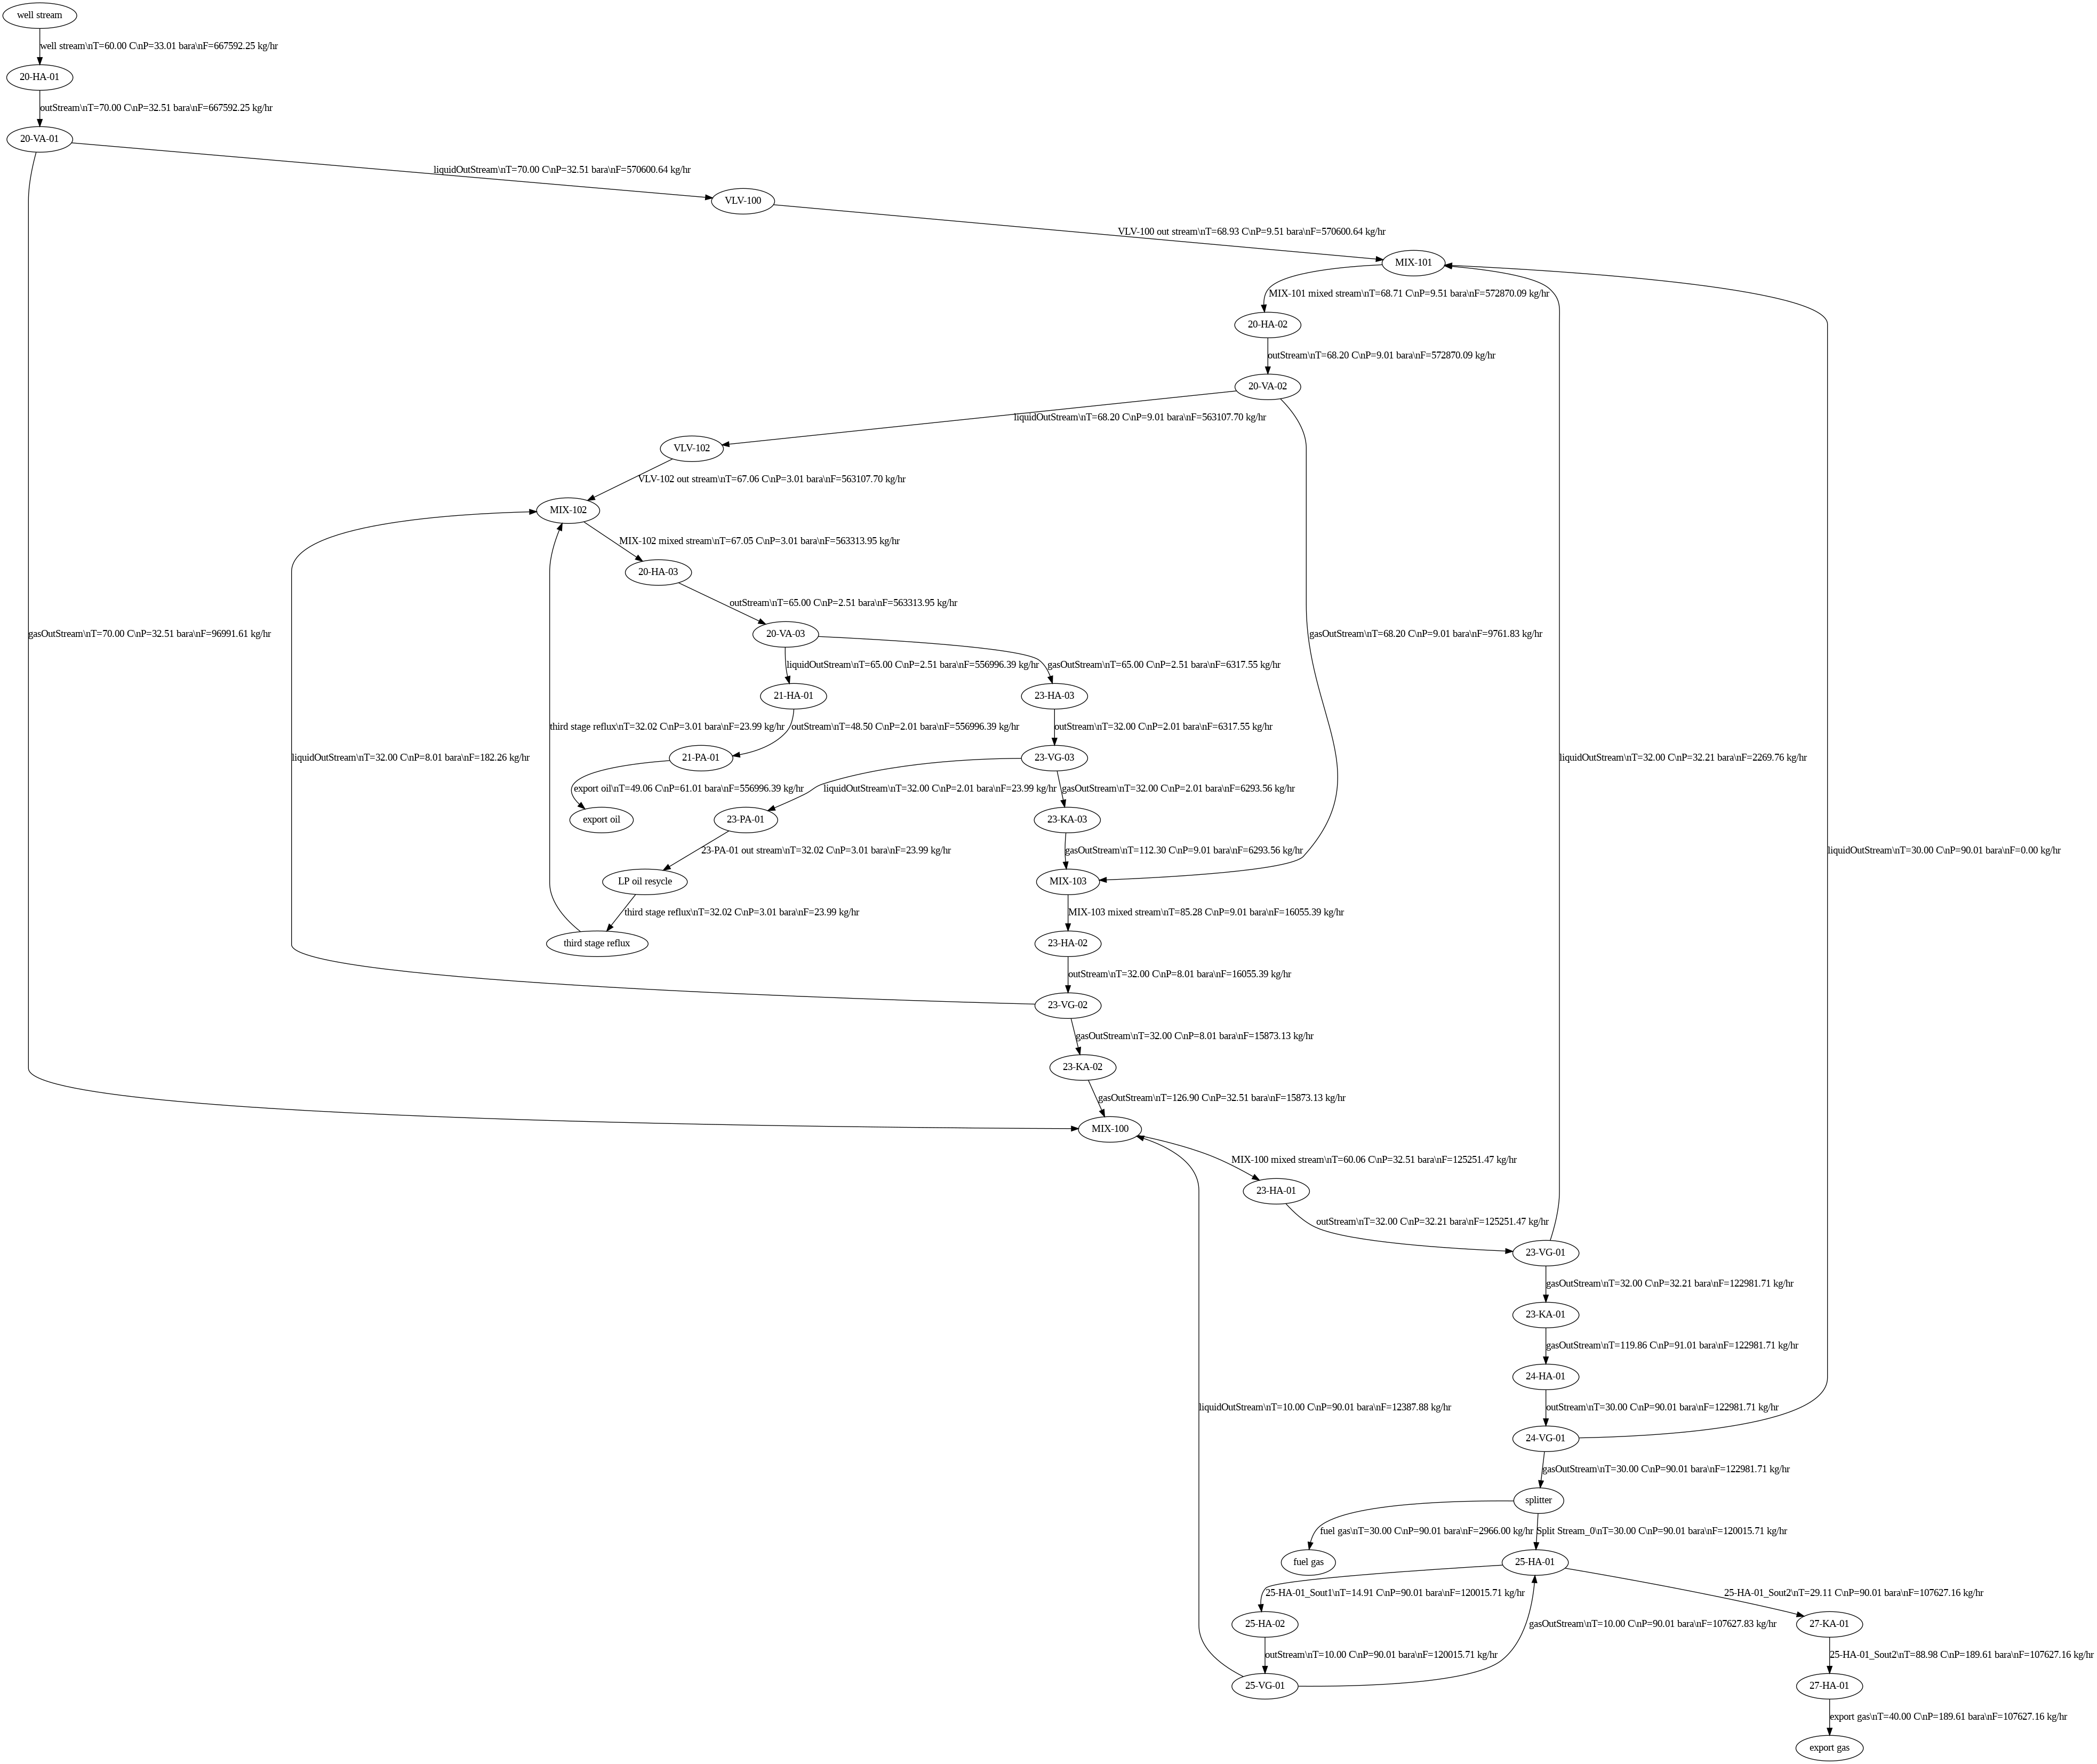

In [9]:
import graphviz
from neqsim import jneqsim

options = neqsim.process.processmodel.ProcessSystemGraphvizExporter.GraphvizExportOptions.builder().includeStreamTemperatures(True).includeStreamPressures(True).includeStreamFlowRates(True).includeStreamPropertyTable(False).tablePlacement(
                neqsim.process.processmodel.ProcessSystemGraphvizExporter.GraphvizExportOptions.TablePlacement.BELOW).build()

process1.exportToGraphviz("test.dot", options)

# Read the dot file
with open('test.dot', 'r') as f:
    dot_graph = f.read()

# Render the dot file and display it
graphviz.Source(dot_graph).render("process_flow_diagram", format="png", cleanup=True)

from IPython.display import Image
Image('process_flow_diagram.png')

All results are returned in results.

In [10]:
results.results

{'LP oil resycle': {'data': {'outlet mass flow': {'value': '23.993684219602596',
    'unit': 'kg/hr'},
   'error pressure': {'value': '0.0', 'unit': ''},
   'outlet pressure': {'value': '3.01325', 'unit': 'bara'},
   'error composition': {'value': '0.0', 'unit': ''},
   'outlet temperature': {'value': '32.018518018189354', 'unit': 'C'},
   'error flow': {'value': '0.0', 'unit': ''},
   'error temperature': {'value': '0.0', 'unit': ''}},
  'tagName': '',
  'name': 'LP oil resycle'},
 '20-HA-01': {'data': {'inlet temperature': {'value': '60.0', 'unit': 'C'},
   'outlet pressure': {'value': '32.51325', 'unit': 'bara'},
   'mass flow': {'value': '667592.2495109844', 'unit': 'kg/hr'},
   'duty': {'value': '4297401.8976076245', 'unit': 'W'},
   'inlet pressure': {'value': '33.01325', 'unit': 'bara'},
   'outlet temperature': {'value': '70.0', 'unit': 'C'}},
  'tagName': '',
  'name': '20-HA-01'},
 '20-HA-02': {'data': {'inlet temperature': {'value': '68.71098696848026',
    'unit': 'C'},
   

In [11]:
#NeqSim process models can be saved and opened using
from neqsim import save_neqsim

save_neqsim(process1, 'process1.neqsim')

from neqsim import open_neqsim

process1 = open_neqsim('process1.neqsim')

# Evaluation of export gas and export oil streams

In [12]:
print('mass balance ', results.mass_balance)
print('gas export rate ',float(results.results['export gas']['conditions']['overall']['molar flow']['value'])/1e3, ' [kmole/hr]')
print('oil export rate ',float(results.results['export oil']['conditions']['overall']['molar flow']['value'])/1e3, ' [kmole/hr]')
print('oil molecular weight ',float(results.results['export oil']['properties']['overall']['molar mass']['value'])*1e3, ' [gr/mole]')
print('gas molecular weight ',float(results.results['export gas']['properties']['overall']['molar mass']['value'])*1e3, ' [gr/mole]')
print('RVP oil export ',float(results.results['export oil']['properties']['oil']['RVP']['value'])*14.5038, ' [psia] (37.8C)')
print('TVP oil export ',float(results.results['export oil']['properties']['oil']['TVP']['value']), 'bara')
print('GCV gas export ',float(results.results['export gas']['properties']['gas']['GCV (15/15)']['value']), ' [MJ/Sm3] 15C/15C')
print('WI gas export ',float(results.results['export gas']['properties']['gas']['WI (15/15)']['value']), ' [MJ/Sm3] 15C/15C')

mass balance  0.00040389106684710557
gas export rate  5111.623339638523  [kmole/hr]
oil export rate  2753.352906615146  [kmole/hr]
oil molecular weight  202.29749295296847  [gr/mole]
gas molecular weight  21.055378260828387  [gr/mole]
RVP oil export  10.254924485512083  [psia] (37.8C)
TVP oil export  1.7263685502087565 bara
GCV gas export  45.677813409100885  [MJ/Sm3] 15C/15C
WI gas export  53.490610554440565  [MJ/Sm3] 15C/15C


In [13]:
results.results['export gas']['properties']['gas']

{'relative density': {'value': '0.7292148464738399', 'unit': '[-]'},
 'gas flow': {'value': '120863.45754281977', 'unit': 'Sm3/hr'},
 'heat capacity (Cv)': {'value': '1.7873839405455842', 'unit': 'kJ/kgK'},
 'molar mass': {'value': '0.021055378260828386', 'unit': 'kg/mol'},
 'WI (15/15)': {'value': '53.490610554440565', 'unit': 'MJ/Sm3 @15C,15C'},
 'entropy': {'value': '-1958.1620695845984', 'unit': 'J/kgK'},
 'density': {'value': '201.84359386796538', 'unit': 'kg/m3'},
 'standard flow rate': {'value': '120863.45754281977', 'unit': 'Sm3/hr'},
 'enthalpy': {'value': '-128944.87249724599', 'unit': 'J/kg'},
 'GCV (15/15)': {'value': '45.677813409100885', 'unit': 'MJ/Sm3 @15C,15C'},
 'flow rate': {'value': '533.2206035400437', 'unit': 'm3/hr'},
 'heat capacity (Cp)': {'value': '3.392353452385184', 'unit': 'kJ/kgK'}}

# Evaluation of heater and cooler duties

In [14]:
print('20-HA-01 ', float(results.results['20-HA-01']['data']['duty']['value'])/1e3, ' kW')
print('20-HA-03 ', float(results.results['20-HA-03']['data']['duty']['value'])/1e3, ' kW')
print('21-HA-01 ', float(results.results['21-HA-01']['data']['duty']['value'])/1e3, ' kW')
print('23-HA-01 ', float(results.results['23-HA-01']['data']['duty']['value'])/1e3, ' kW')
print('23-HA-02 ', float(results.results['23-HA-02']['data']['duty']['value'])/1e3, ' kW')
print('23-HA-03 ', float(results.results['23-HA-03']['data']['duty']['value'])/1e3, ' kW')
print('24-HA-01 ', float(results.results['24-HA-01']['data']['duty']['value'])/1e3, ' kW')
print('25-HA-01 ', results.results['25-HA-01']['duty']/1e3, ' kW')
print('25-HA-02 ', float(results.results['25-HA-02']['data']['duty']['value'])/1e3, ' kW')
print('27-HA-01 ', float(results.results['27-HA-01']['data']['duty']['value'])/1e3, ' kW')

20-HA-01  4297.401897607625  kW
20-HA-03  -587.270733895123  kW
21-HA-01  -5343.251479539722  kW
23-HA-01  -2379.635486869782  kW
23-HA-02  -487.2582278890826  kW
23-HA-03  -108.0616322605416  kW
24-HA-01  -8534.97808367051  kW
25-HA-01  1885.2320372116203  kW
25-HA-02  -649.902396686757  kW
27-HA-01  -4694.922366387339  kW


In [15]:
results.results['25-HA-01']

{'feedTemperature1': 30.0,
 'dischargeTemperature1': 14.90520612571089,
 'HXthermalEfectiveness': 0.9586675274221941,
 'feedTemperature2': 10.0,
 'dischargeTemperature2': 29.114934868385717,
 'dutyBalance': 1.0,
 'duty': 1885232.0372116202,
 'UAvalue': 800000.0,
 'tagName': '',
 'name': '25-HA-01'}

# Evaluation of compressor simulations

In [16]:
print('power')
print('23-KA-01 ', results.results['23-KA-01']['power'], ' kW')
print('23-KA-02 ', results.results['23-KA-02']['power'], ' kW')
print('23-KA-03 ', results.results['23-KA-03']['power'], ' kW')
print('27-KA-01 ', results.results['27-KA-01']['power'], ' kW')
print('21-PA-01 ', results.results['21-PA-01']['power']/1e3, ' kW')
print('discharge temperatures')
print('23-KA-01 ', results.results['23-KA-01']['dischargeTemperature'], ' C')
print('23-KA-02 ', results.results['23-KA-02']['dischargeTemperature'], ' C')
print('23-KA-03 ', results.results['23-KA-03']['dischargeTemperature'], ' C')
print('27-KA-01 ', results.results['27-KA-01']['dischargeTemperature'], ' C')
print('21-PA-01 ', results.results['21-PA-01']['dischargeTemperature'], ' C')

power
23-KA-01  5335.864948400899  kW
23-KA-02  749.9922802838911  kW
23-KA-03  254.8945171203974  kW
27-KA-01  2947.392750408833  kW
21-PA-01  1087.985965896815  kW
discharge temperatures
23-KA-01  119.85674440758879  C
23-KA-02  126.89790507625725  C
23-KA-03  112.29851661562867  C
27-KA-01  88.98008604051921  C
21-PA-01  49.06083946320109  C


In [17]:
results.results['27-KA-01']

{'suctionTemperature': 29.114934868385717,
 'dischargeTemperature': 88.98008604051921,
 'suctionPressure': 90.01325,
 'dischargePressure': 189.61325,
 'polytropicHead': 73.94007431303194,
 'polytropicEfficiency': 0.75,
 'power': 2947.392750408833,
 'suctionVolumeFlow': 1063.7807265267459,
 'dischargeVolumeFlow': 703.901850871971,
 'molarMass': 0.021055378260828386,
 'suctionMassDensity': 100.46813387737227,
 'dischargeMassDensity': 152.90080969334417,
 'massflow': 107627.16294296796,
 'stdFlow': 120863.45754281977,
 'speed': 3000.0,
 'tagName': '',
 'name': '27-KA-01'}

# Parametric studies (run 100 simulations with varying input parameters)
In the following example, we assume that each input parameter can vary by a maximum of 10%. We run 100 calculations where the input parameters are varied randomly.

In [ ]:
import numpy as np
import random


def vary_parameter(param_value, variation=0.1):
    """
    Vary the parameter value by a given percentage.
    """
    if isinstance(param_value, (list, np.ndarray)):
        return param_value  # Don't vary list/array type parameters
    else:
        return param_value * (1 + random.uniform(-variation, variation))

# Function to run the simulation
def run_simulation_variations(base_params, num_simulations=100, variation=0.1):
    results = []
    for i in range(num_simulations):
        print('running simulation ' ,i)
        varied_params = {}
        for key, value in base_params.items():
            if isinstance(value, (list, np.ndarray)):
                varied_params[key] = value  # Don't vary list/array type parameters
            else:
                varied_params[key] = vary_parameter(value, variation)
        result = run_simulation(process=process1, input_params=varied_params)
        results.append(result)
    return results

# Run the simulations
simulation_results = run_simulation_variations(inputparam)

# Process the results as needed
for idx, result in enumerate(simulation_results):
    print(f"Simulation {idx + 1}: {result}")


running simulation  0
running simulation  1
running simulation  2
running simulation  3
running simulation  4
running simulation  5
running simulation  6
running simulation  7
running simulation  8
running simulation  9
running simulation  10
running simulation  11
running simulation  12


# Example of optimization of the process
Only for illustrative purpose..

Below is Python code that uses the scipy.optimize module to minimize the total power consumption of your oil process simulation by optimizing specific input parameters. This code sets up an optimization problem where the objective is to minimize the total power used by compressors and pumps, given certain constraints and bounds on the input parameters.

In [ ]:
from scipy.optimize import minimize
import numpy as np

# Define the variable names, initial values, and bounds
variable_names = [
    'Tsep1', 'Tsep2', 'Tsep3', 'Tscrub1', 'Tscrub2', 'Tscrub3', 'Tscrub4',
    'Psep1', 'Psep2', 'Psep3', 'Pcomp1', 'P_gas_export', 'Trefig', 'P_oil_export', 'T_oil_export'
]

initial_values = [
    70.0, 68.2, 65.0, 32.0, 32.0, 32.0, 30.0,
    31.5, 8.0, 1.5, 90.0, 188.6, 10.0, 60.0, 48.5
]

bounds = [
    (65.0, 75.0),  # Tsep1
    (65, 70.0),  # Tsep2
    (60.0, 70.0),  # Tsep3
    (0.0, 100.0),  # Tscrub1
    (25.0, 40.0),  # Tscrub2
    (25, 40.0),  # Tscrub3
    (25, 40.0),  # Tscrub4
    (30, 35.0),  # Psep1
    (5, 15.0),  # Psep2
    (1.0, 2.0),  # Psep3
    (90.0, 95.0),  # Pcomp1
    (180, 190.0),  # P_gas_export
    (10.0, 20.0),  # Trefig
    (55.0, 65.0),  # P_oil_export
    (45.0, 50.0)   # T_oil_export
]

# Define constraints to ensure physical feasibility
def constraint_Psep1_Psep2(x):
    idx_Psep1 = variable_names.index('Psep1')
    idx_Psep2 = variable_names.index('Psep2')
    return x[idx_Psep1] - x[idx_Psep2]  # Psep1 >= Psep2

def constraint_Psep2_Psep3(x):
    idx_Psep2 = variable_names.index('Psep2')
    idx_Psep3 = variable_names.index('Psep3')
    return x[idx_Psep2] - x[idx_Psep3]  # Psep2 >= Psep3

def constraint_Tsep1_Tsep2(x):
    idx_Tsep1 = variable_names.index('Tsep1')
    idx_Tsep2 = variable_names.index('Tsep2')
    return x[idx_Tsep1] - x[idx_Tsep2]  # Tsep1 >= Tsep2

def constraint_Tsep2_Tsep3(x):
    idx_Tsep2 = variable_names.index('Tsep2')
    idx_Tsep3 = variable_names.index('Tsep3')
    return x[idx_Tsep2] - x[idx_Tsep3]  # Tsep2 >= Tsep3

def constraint_Pcomp1_Psep1(x):
    idx_Pcomp1 = variable_names.index('Pcomp1')
    idx_Psep1 = variable_names.index('Psep1')
    return x[idx_Pcomp1] - x[idx_Psep1]  # Pcomp1 >= Psep1

constraints = [
    {'type': 'ineq', 'fun': constraint_Psep1_Psep2},
    {'type': 'ineq', 'fun': constraint_Psep2_Psep3},
    {'type': 'ineq', 'fun': constraint_Tsep1_Tsep2},
    {'type': 'ineq', 'fun': constraint_Tsep2_Tsep3},
    {'type': 'ineq', 'fun': constraint_Pcomp1_Psep1}
]

# Define the objective function to minimize total power consumption
def objective_function(x):
    # Map x to input parameters
    input_params = inputparam.copy()
    for i, var_name in enumerate(variable_names):
        input_params[var_name] = x[i]
    try:
        # Run the simulation
        result = run_simulation(process=process1, input_params=input_params)
        if result is None:
            # If simulation failed or timed out, return a large penalty value
            return 1e10
        else:
            # Extract total power consumption
            power1 = result.results['23-KA-01']['power']
            power2 = result.results['23-KA-02']['power']
            power3 = result.results['23-KA-03']['power']
            power4 = result.results['27-KA-01']['power']
            power5 = result.results['21-PA-01']['power'] / 1e3  # Convert to kW if necessary
            total_power = power1 + power2 + power3 + power4 + power5
            return total_power
    except Exception as e:
        print(f"Simulation failed: {e}")
        return 1e10  # Return a large penalty value in case of failure

# Perform the optimization using the 'SLSQP' method
result = minimize(
    objective_function,
    x0=initial_values,
    bounds=bounds,
    method='SLSQP',
    constraints=constraints,
    options={'maxiter': 10}  # Adjust maxiter as needed
)

# Output the optimization results
print("Optimization result:")
print("Status:", result.message)
print("Total power consumption:", result.fun, "kW")
print("Optimized parameters:")
for i, var_name in enumerate(variable_names):
    print(f"{var_name}: {result.x[i]}")

# Run a final simulation with the optimized parameters to get detailed results
optimized_input_params = inputparam.copy()
for i, var_name in enumerate(variable_names):
    optimized_input_params[var_name] = result.x[i]

final_result = run_simulation(process=process1, input_params=optimized_input_params)
print("Final simulation results:")
print('Total power consumption:', objective_function(result.x), 'kW')
print('Mass balance:', final_result.mass_balance)
print('Gas export rate:', float(final_result.results['export gas']['conditions']['overall']['molar flow']['value']) / 1e3, '[kmole/hr]')
print('Oil export rate:', float(final_result.results['export oil']['conditions']['overall']['molar flow']['value']) / 1e3, '[kmole/hr]')


## Combination with machine learning methods
Only for illustrative purpose..

Below is an example of how you can use machine learning to optimize your process by minimizing power consumption based on input parameters.

Approach:

**Data Generation**: Run the process simulation multiple times with varied input parameters to generate a dataset.

**Model Training**: Use the generated dataset to train a machine learning model that predicts total power consumption based on input parameters.

**Optimization**: Use the trained model to predict power consumption across a range of input parameters and apply an optimization algorithm to find the parameters that minimize predicted power consumption.

Implementation Steps:

**Step 1**: Generate a dataset by running simulations with random variations in the input parameters within specified bounds.

**Step 2**: Train a regression model (e.g., Random Forest) to model the relationship between input parameters and power consumption.

**Step 3**: Use the trained model and an optimization algorithm to find the input parameters that minimize predicted power consumption.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from scipy.optimize import minimize

# Define the variable names and bounds
variable_names = [
    'Tsep1', 'Tsep2', 'Tsep3', 'Tscrub1', 'Tscrub2', 'Tscrub3', 'Tscrub4',
    'Psep1', 'Psep2', 'Psep3', 'Pcomp1', 'P_gas_export', 'Trefig', 'P_oil_export', 'T_oil_export'
]

bounds = [
    (65.0, 75.0),    # Tsep1
    (65.0, 70.0),    # Tsep2
    (60.0, 70.0),    # Tsep3
    (25.0, 40.0),    # Tscrub1
    (25.0, 40.0),    # Tscrub2
    (25.0, 40.0),    # Tscrub3
    (25.0, 40.0),    # Tscrub4
    (30.0, 35.0),    # Psep1
    (5.0, 15.0),     # Psep2
    (1.0, 2.0),     # Psep3
    (90.0, 95.0),    # Pcomp1
    (180.0, 190.0),  # P_gas_export
    (10.0, 20.0),    # Trefig
    (55.0, 65.0),    # P_oil_export
    (45.0, 50.0)     # T_oil_export
]

# Step 1: Generate Training Data
def generate_training_data(num_samples=100):
    data = []
    for _ in range(num_samples):
        sample = {}
        for idx, var_name in enumerate(variable_names):
            low, high = bounds[idx]
            sample[var_name] = np.random.uniform(low, high)
        input_params = inputparam.copy()
        input_params.update(sample)
        try:
            # Run the simulation
            result = run_simulation(process=process1, input_params=input_params)
            if result is not None:
                # Extract total power consumption
                power1 = result.results['23-KA-01']['power']
                power2 = result.results['23-KA-02']['power']
                power3 = result.results['23-KA-03']['power']
                power4 = result.results['27-KA-01']['power']
                power5 = result.results['21-PA-01']['power'] / 1e3  # Convert to kW if necessary
                total_power = power1 + power2 + power3 + power4 + power5
                sample['total_power'] = total_power
                data.append(sample)
        except Exception as e:
            print(f"Simulation failed: {e}")
            continue
    return pd.DataFrame(data)

# Generate the dataset
training_data = generate_training_data(num_samples=200)

# Step 2: Train a Machine Learning Model
# Separate features and target variable
X = training_data[variable_names]
y = training_data['total_power']

# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Step 3: Optimize Using the Trained Model
# Define the objective function using the trained model
def ml_objective_function(x):
    x = np.array(x).reshape(1, -1)
    predicted_power = model.predict(x)[0]
    return predicted_power

# Constraints (same as before)
def constraint_Psep1_Psep2(x):
    idx_Psep1 = variable_names.index('Psep1')
    idx_Psep2 = variable_names.index('Psep2')
    return x[idx_Psep1] - x[idx_Psep2]  # Psep1 >= Psep2

def constraint_Psep2_Psep3(x):
    idx_Psep2 = variable_names.index('Psep2')
    idx_Psep3 = variable_names.index('Psep3')
    return x[idx_Psep2] - x[idx_Psep3]  # Psep2 >= Psep3

def constraint_Tsep1_Tsep2(x):
    idx_Tsep1 = variable_names.index('Tsep1')
    idx_Tsep2 = variable_names.index('Tsep2')
    return x[idx_Tsep1] - x[idx_Tsep2]  # Tsep1 >= Tsep2

def constraint_Tsep2_Tsep3(x):
    idx_Tsep2 = variable_names.index('Tsep2')
    idx_Tsep3 = variable_names.index('Tsep3')
    return x[idx_Tsep2] - x[idx_Tsep3]  # Tsep2 >= Tsep3

def constraint_Pcomp1_Psep1(x):
    idx_Pcomp1 = variable_names.index('Pcomp1')
    idx_Psep1 = variable_names.index('Psep1')
    return x[idx_Pcomp1] - x[idx_Psep1]  # Pcomp1 >= Psep1

constraints = [
    {'type': 'ineq', 'fun': constraint_Psep1_Psep2},
    {'type': 'ineq', 'fun': constraint_Psep2_Psep3},
    {'type': 'ineq', 'fun': constraint_Tsep1_Tsep2},
    {'type': 'ineq', 'fun': constraint_Tsep2_Tsep3},
    {'type': 'ineq', 'fun': constraint_Pcomp1_Psep1}
]

# Initial guess
x0 = [ (b[0] + b[1]) / 2 for b in bounds ]

# Perform the optimization
result = minimize(
    ml_objective_function,
    x0=x0,
    bounds=bounds,
    method='SLSQP',
    constraints=constraints,
    options={'maxiter': 100}
)

# Output the optimization results
print("Optimization result:")
print("Status:", result.message)
print("Predicted Total Power Consumption:", result.fun, "kW")
print("Optimized Parameters:")
for i, var_name in enumerate(variable_names):
    print(f"{var_name}: {result.x[i]}")

# Run a final simulation with the optimized parameters to validate
optimized_input_params = inputparam.copy()
for i, var_name in enumerate(variable_names):
    optimized_input_params[var_name] = result.x[i]

final_result = run_simulation(process=process1, input_params=optimized_input_params)
if final_result is not None:
    power1 = final_result.results['23-KA-01']['power']
    power2 = final_result.results['23-KA-02']['power']
    power3 = final_result.results['23-KA-03']['power']
    power4 = final_result.results['27-KA-01']['power']
    power5 = final_result.results['21-PA-01']['power'] / 1e3  # Convert to kW if necessary
    total_power = power1 + power2 + power3 + power4 + power5

    print("Final Simulation Results:")
    print("Actual Total Power Consumption:", total_power, "kW")
    print('Mass balance:', final_result.mass_balance)
    print('Gas export rate:', float(final_result.results['export gas']['conditions']['overall']['molar flow']['value']) / 1e3, '[kmole/hr]')
    print('Oil export rate:', float(final_result.results['export oil']['conditions']['overall']['molar flow']['value']) / 1e3, '[kmole/hr]')
else:
    print("Simulation failed with optimized parameters.")
